In [1]:
import warnings, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from typing import Dict

from scipy.stats import shapiro, normaltest

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima.preprocessing import BoxCoxEndogTransformer

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.4f}".format)
sns.set_theme(style="darkgrid")

print("Using pandas:", pd.__version__, "| statsmodels:", sm.__version__)

Using pandas: 2.0.1 | statsmodels: 0.14.0


In [2]:
#Helpers 

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(1e-9, np.abs(y_true))))

def smape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-9, denom)
    return np.mean(np.abs(y_true - y_pred) / denom)

def normality_test(y):
    y = pd.Series(y).dropna()
    try:
        stat_s, p_s = shapiro(y.sample(min(5000, len(y)), random_state=42))
    except Exception:
        stat_s, p_s = np.nan, np.nan
    stat_d, p_d = normaltest(y)
    return {"shapiro_p": float(p_s), "dagostino_p": float(p_d)}

def evaluate_model(name, y_true, y_pred, results):
    results.append({
        "model": name,
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
        "SMAPE": smape(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    })


# 1) Data Acquisition

In [3]:
from pandas_datareader import data as web

start = "1992-01-01"
data = None
try:
    rs = web.DataReader("RSXFS", "fred", start).rename(columns={"RSXFS":"retail"})
    un = web.DataReader("UNRATE", "fred", start).rename(columns={"UNRATE":"unrate"})
    sent = web.DataReader("UMCSENT", "fred", start).rename(columns={"UMCSENT":"sentiment"})
    data = rs.join(un, how="outer").join(sent, how="outer").dropna().asfreq("MS")
    data.index.name = "date"
except Exception as e:
    print("Failed to fetch data:", e)
    raise SystemExit("Exiting — please provide the datasets manually.")

print("Data shape:", data.shape)
display(data.head())
display(data.describe())


Data shape: (404, 3)


,retail,unrate,sentiment
date,,,
1992-01-01,142419,7.3000,67.5000
1992-02-01,142584,7.4000,68.8000
1992-03-01,142120,7.4000,76.0000
1992-04-01,143659,7.4000,77.2000
1992-05-01,144239,7.6000,79.2000


,retail,unrate,sentiment
count,404.0000,404.0000,404.0000
mean,336134.6510,5.6532,85.0505
std,129261.6374,1.7829,13.8302
min,142120.0000,3.4000,50.0000
25%,242125.0000,4.3000,74.3000
50%,317841.5000,5.2000,88.1500
75%,407761.2500,6.5000,95.3250
max,632490.0000,14.8000,112.0000


# 2) Visualization

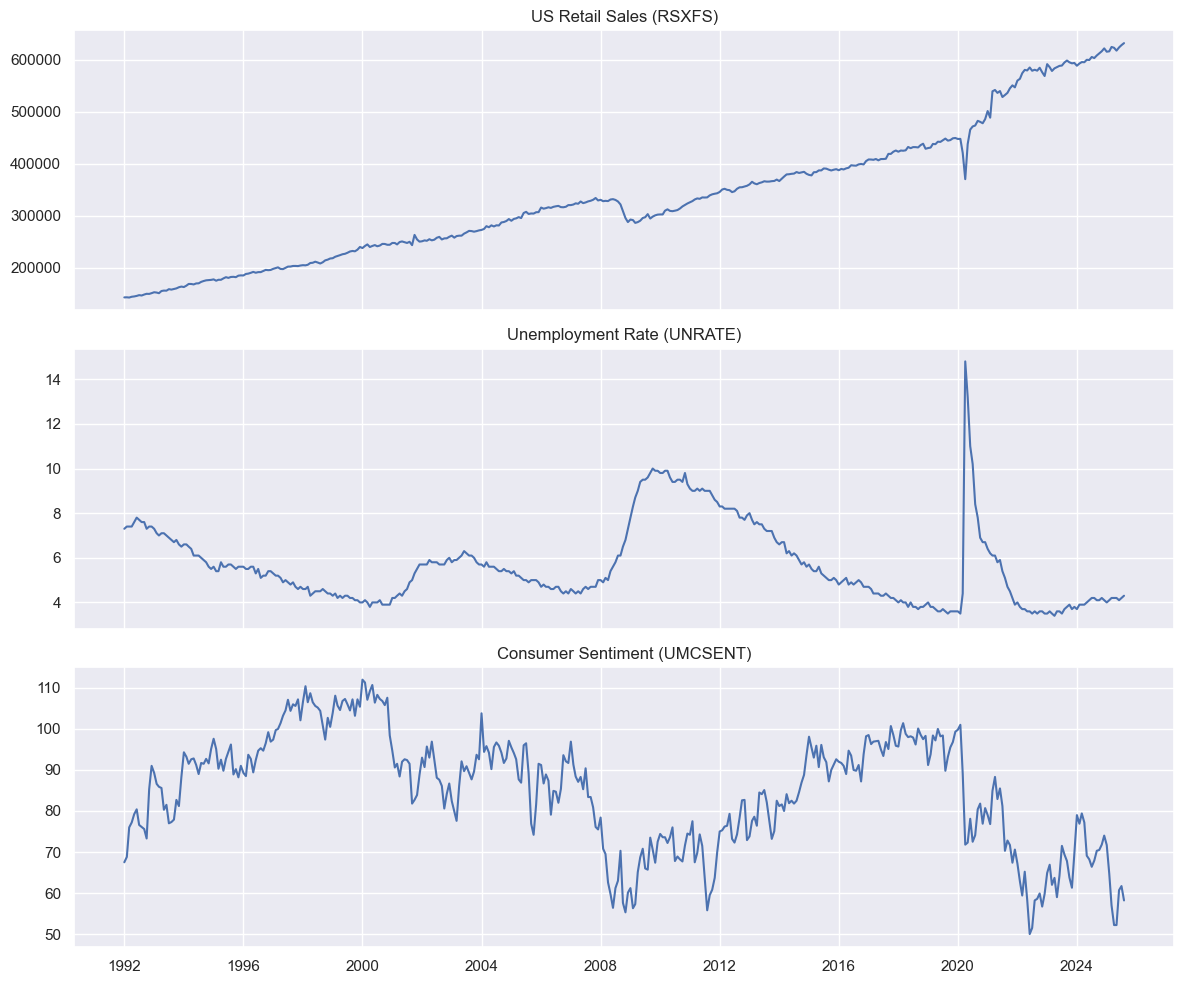

In [5]:
#PLOT RAW DATA ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes[0].plot(data.index, data['retail'])
axes[0].set_title('US Retail Sales (RSXFS)')
axes[1].plot(data.index, data['unrate'])
axes[1].set_title('Unemployment Rate (UNRATE)')
axes[2].plot(data.index, data['sentiment'])
axes[2].set_title('Consumer Sentiment (UMCSENT)')
plt.tight_layout()
plt.show()

# 3) Stationarity & ACF/PACF 


ADF Test: Retail (level)
Statistic: 1.269382767543298 | p-value: 0.9964318832448728
Critical Value (1%): -3.4471
Critical Value (5%): -2.8689
Critical Value (10%): -2.5707

ADF Test: Retail (1st diff)
Statistic: -5.058201757689372 | p-value: 1.7001625019195625e-05
Critical Value (1%): -3.4471
Critical Value (5%): -2.8689
Critical Value (10%): -2.5707


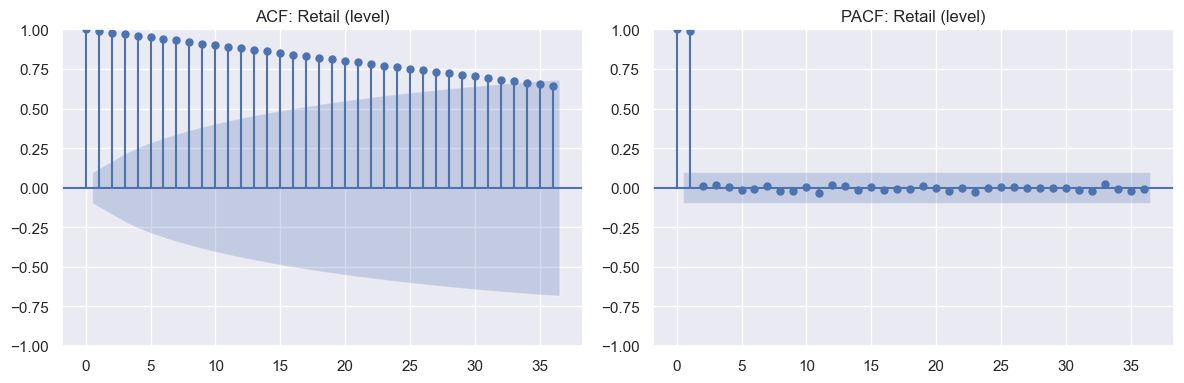

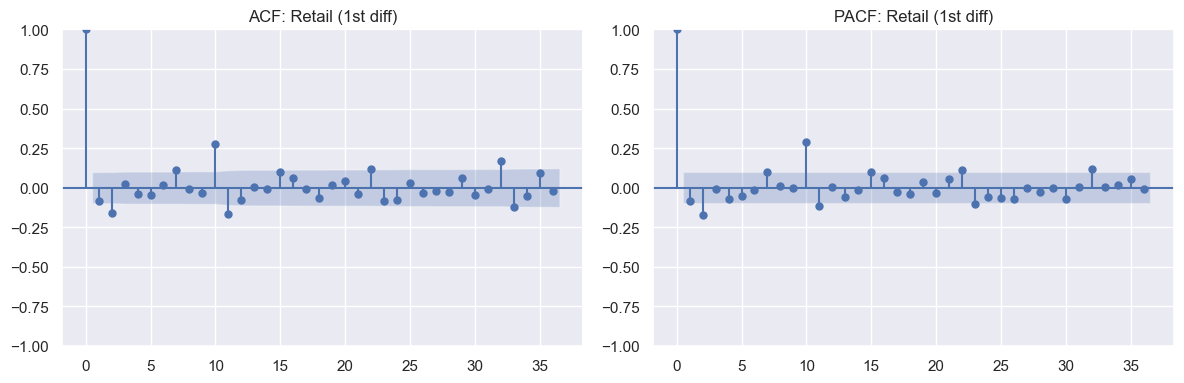

In [7]:
def adf_report(series, title="Series"):
    res = adfuller(series.dropna(), autolag='AIC')
    print(f"\nADF Test: {title}")
    print("Statistic:", res[0], "| p-value:", res[1])
    for key, val in res[4].items():
        print(f"Critical Value ({key}): {val:.4f}")

adf_report(data['retail'], "Retail (level)")
adf_report(data['retail'].diff(), "Retail (1st diff)")

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['retail'].dropna(), ax=ax[0], lags=36)
plot_pacf(data['retail'].dropna(), ax=ax[1], lags=36, method='ywm')
ax[0].set_title("ACF: Retail (level)")
ax[1].set_title("PACF: Retail (level)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['retail'].diff().dropna(), ax=ax[0], lags=36)
plot_pacf(data['retail'].diff().dropna(), ax=ax[1], lags=36, method='ywm')
ax[0].set_title("ACF: Retail (1st diff)")
ax[1].set_title("PACF: Retail (1st diff)")
plt.tight_layout()
plt.show()


# 4) Train/Test Split

In [8]:
# --- Split the data into train/test ---
cutoff = (data.index.max() - pd.offsets.DateOffset(years=2)).strftime("%Y-%m-01")
train, test = data.loc[:cutoff], data.loc[cutoff:]
print("Train data:", train.index.min(), "→", train.index.max(), "| Shape:", train.shape)
print("Test data :", test.index.min(), "→", test.index.max(), "| Shape:", test.shape)

y_train = train['retail']
y_test = test['retail']
exog_train = train[['unrate', 'sentiment']]
exog_test = test[['unrate', 'sentiment']]

Train data: 1992-01-01 00:00:00 → 2023-08-01 00:00:00 | Shape: (380, 3)
Test data : 2023-08-01 00:00:00 → 2025-08-01 00:00:00 | Shape: (25, 3)


#  5) Task 1 — AR, MA, ARMA, ARIMA

In [12]:
results_tbl = []

# --- Function to suggest p and q from ACF/PACF ---
from statsmodels.tsa.stattools import acf as acf_vals, pacf as pacf_vals

def suggest_orders(y, max_lag=24):
    y = pd.Series(y).dropna()
    ac = acf_vals(y, nlags=max_lag, fft=True)
    pc = pacf_vals(y, nlags=max_lag, method='ywm')
    band = 1.96 / np.sqrt(len(y))
    p_cut = next((lag for lag in range(1, max_lag + 1) if abs(pc[lag]) < band), 1) - 1
    q_cut = next((lag for lag in range(1, max_lag + 1) if abs(ac[lag]) < band), 1) - 1
    p_cut = int(max(0, min(p_cut, 12)))
    q_cut = int(max(0, min(q_cut, 12)))
    print(f"[Rationale] Suggested p from PACF cutoff: {p_cut}; q from ACF cutoff: {q_cut}")
    return p_cut, q_cut

# --- Get suggestions from ACF/PACF ---
y_train_diff = y_train.diff().dropna()
p_sug, q_sug = suggest_orders(y_train_diff)
p_grid = sorted(set([max(1, p_sug - 1), max(1, p_sug), min(12, p_sug + 1)]))
q_grid = sorted(set([max(1, q_sug - 1), max(1, q_sug), min(12, q_sug + 1)]))
print(f"[Grid] Trying p values: {p_grid}; q values: {q_grid}")

# --- Fit AR model on differenced data ---
best_ar = None
best_aic = np.inf
for p in p_grid:
    try:
        fit = ARIMA(y_train_diff, order=(p, 0, 0)).fit()
        if fit.aic < best_aic:
            best_aic, best_ar = fit.aic, (p, fit)
    except:
        continue
p, ar_fit = best_ar
ar_fc_diff = ar_fit.get_forecast(steps=len(y_test)).predicted_mean
ar_fc_level = y_train.iloc[-1] + ar_fc_diff.cumsum()
evaluate_model(f"AR({p}) on diff (inverted)", y_test, ar_fc_level, results_tbl)

# --- Fit MA model ---
best_ma = None
best_aic = np.inf
for q in q_grid:
    try:
        fit = ARIMA(y_train_diff, order=(0, 0, q)).fit()
        if fit.aic < best_aic:
            best_aic, best_ma = fit.aic, (q, fit)
    except:
        continue
q, ma_fit = best_ma
ma_fc_diff = ma_fit.get_forecast(steps=len(y_test)).predicted_mean
ma_fc_level = y_train.iloc[-1] + ma_fc_diff.cumsum()
evaluate_model(f"MA({q}) on diff (inverted)", y_test, ma_fc_level, results_tbl)

# --- Fit ARMA model ---
best_arma = None
best_aic = np.inf
best_tuple = None
for p in p_grid:
    for q in q_grid:
        try:
            fit = ARIMA(y_train_diff, order=(p, 0, q)).fit()
            if fit.aic < best_aic:
                best_aic, best_arma, best_tuple = fit.aic, fit, (p, q)
        except:
            continue
p_best, q_best = best_tuple
arma_fc_diff = best_arma.get_forecast(steps=len(y_test)).predicted_mean
arma_fc_level = y_train.iloc[-1] + arma_fc_diff.cumsum()
evaluate_model(f"ARMA({p_best},{q_best}) on diff (inverted)", y_test, arma_fc_level, results_tbl)

# --- Try multiple ARIMA configs on level data ---
best_arima = None
best_aic = np.inf
for d in [0, 1]:
    for p in [0, 1, 2, 3, 6, 12]:
        for q in [0, 1, 2, 3]:
            if p == 0 and q == 0 and d == 0:
                continue
            try:
                fit = ARIMA(y_train, order=(p, d, q)).fit()
                if fit.aic < best_aic:
                    best_aic, best_arima = fit.aic, ((p, d, q), fit)
            except:
                continue
(p, d, q), arima_fit = best_arima
arima_fc = arima_fit.get_forecast(steps=len(y_test)).predicted_mean
evaluate_model(f"ARIMA({p},{d},{q})", y_test, arima_fc, results_tbl)
pd.DataFrame(results_tbl).sort_values(["RMSE","SMAPE"]).reset_index(drop=True)

[Rationale] Suggested p from PACF cutoff: 0; q from ACF cutoff: 0
[Grid] Trying p values: [1]; q values: [1]


,model,RMSE,MAE,MAPE,SMAPE,R2
0,"ARMA(1,1) on diff (inverted)",5773.8824,4833.8250,0.0080,0.0080,0.8010
1,MA(1) on diff (inverted),5972.6436,4961.6211,0.0082,0.0082,0.7871
2,AR(1) on diff (inverted),6044.5446,5034.7901,0.0083,0.0083,0.7819
3,"ARIMA(12,0,2)",17962.2465,13789.4315,0.0223,0.0227,-0.9259


# 6) Task 2 — Auto ARIMA with Box‑Cox & Exogenous Variables (UNRATE, UMCSENT)

Normality p-values: {'shapiro_p': 5.138240499746871e-09, 'dagostino_p': 7.82303850887394e-05}
Box-Cox: Applied
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7622.062, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7625.018, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7625.015, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9507.953, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=7623.538, Time=0.33 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=7623.499, Time=0.28 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=7625.465, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=7623.584, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=7623.603, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=7625.705, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 2.632 seconds
                               SARIMAX Results                                
Dep. Variable:     

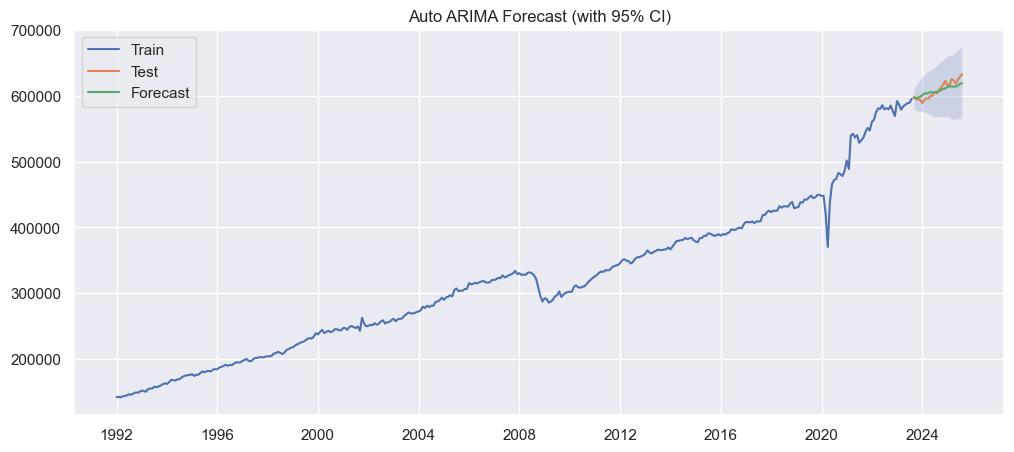

In [11]:
norm_stats = normality_test(y_train)
print("Normality p-values:", norm_stats)
do_boxcox = (norm_stats.get("dagostino_p", 1.0) < 0.05) or (norm_stats.get("shapiro_p", 1.0) < 0.05)
endog_transformer = BoxCoxEndogTransformer(lmbda2=1e-6) if do_boxcox else None
print("Box-Cox:", "Applied" if do_boxcox else "Skipped")

# --- Clean up exogenous vars ---
exog_train_clean = exog_train.replace([np.inf, -np.inf], np.nan).ffill().bfill().reindex(y_train.index).ffill().bfill()
exog_test_clean = exog_test.replace([np.inf, -np.inf], np.nan).ffill().bfill().reindex(y_test.index).ffill().bfill()

# --- Auto ARIMA with exogenous variables ---
auto_model = pm.auto_arima(
    y=y_train,
    X=exog_train_clean,
    start_p=0, start_q=0, max_p=5, max_q=5,
    d=None, D=None,
    seasonal=True, m=12,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    with_intercept=True,
    trace=True,
    stepwise=True,
    information_criterion="aic",
    error_action="ignore",
    suppress_warnings=True,
    endog_transform=endog_transformer
)
print(auto_model.summary())

# --- Forecast and evaluate ---
h = len(y_test)
pred, conf = auto_model.predict(n_periods=h, X=exog_test_clean, return_conf_int=True)
pred = pd.Series(pred, index=y_test.index, dtype="float64")
eval_auto = pd.DataFrame({"y": y_test.astype("float64"), "pred": pred.replace([np.inf, -np.inf], np.nan)}).dropna()

conf_df = None
if isinstance(conf, np.ndarray):
    conf_df = pd.DataFrame(conf, index=y_test.index, columns=["lower", "upper"]).loc[eval_auto.index]

evaluate_model("Auto ARIMA + exog" + (" + BoxCox" if do_boxcox else ""), eval_auto["y"], eval_auto["pred"], results_tbl)

# --- Plot forecast ---
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(eval_auto.index, eval_auto["y"], label="Test")
plt.plot(eval_auto.index, eval_auto["pred"], label="Forecast")
if conf_df is not None:
    plt.fill_between(conf_df.index, conf_df["lower"], conf_df["upper"], alpha=0.2)
plt.legend()
plt.title("Auto ARIMA Forecast (with 95% CI)")
plt.show()

In [13]:
final_results = pd.DataFrame(results_tbl).sort_values(["RMSE", "SMAPE"]).reset_index(drop=True)
display(final_results)

best = final_results.iloc[0].to_dict()
print("\nBest model based on RMSE & SMAPE:")
for k, v in best.items():
    if k != "model":
        print(f"{k:>6}: {v:.4f}")
print("Model:", best["model"])

,model,RMSE,MAE,MAPE,SMAPE,R2
0,"ARMA(1,1) on diff (inverted)",5773.8824,4833.8250,0.0080,0.0080,0.8010
1,MA(1) on diff (inverted),5972.6436,4961.6211,0.0082,0.0082,0.7871
2,AR(1) on diff (inverted),6044.5446,5034.7901,0.0083,0.0083,0.7819
3,"ARIMA(12,0,2)",17962.2465,13789.4315,0.0223,0.0227,-0.9259



Best model based on RMSE & SMAPE:
  RMSE: 5773.8824
   MAE: 4833.8250
  MAPE: 0.0080
 SMAPE: 0.0080
    R2: 0.8010
Model: ARMA(1,1) on diff (inverted)
